In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import time

In [2]:
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import *
from tensorflow.keras.callbacks import *

In [3]:
CLASS_NAMES= ['healthy', 'mild', 'moderate', 'severe']
IMG_HEIGHT = 128
IMG_WIDTH = 128
CHANNELS = 3
NUM_CLASSES = len(CLASS_NAMES)

# **ResNET**

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
#load data
data_x = np.load('data_x_aumentated_normalized.npy') #images
data_y = np.load('data_y_aumentated_normalized.npy') #labels
TOTAL_IMAGES = len(data_y)
print("TOTAL_IMAGES = ", TOTAL_IMAGES)

TOTAL_IMAGES =  2368


# **Splitting data in train - validation - test**

In [6]:
#percentage of the dataset which will be on TRAIN - TEST - VALIDATION
TRAIN_PERCENTAGE = 0.8
TEST_PERCENTAGE = 0.1
VALIDATION_PERCENTAGE = 0.1

In [7]:
train_size = int(TRAIN_PERCENTAGE * TOTAL_IMAGES)
test_size = int(TEST_PERCENTAGE * TOTAL_IMAGES)
validation_size = int(VALIDATION_PERCENTAGE * TOTAL_IMAGES)

In [8]:
train_x = data_x[:train_size]
train_y = data_y[:train_size]
data_x = data_x[train_size:]
data_y = data_y[train_size:]

test_x = data_x[:test_size]
test_y = data_y[:test_size]
data_x = data_x[test_size:]
data_y = data_y[test_size:]

validation_x = data_x #all the remainder we can let on validation
validation_y = data_y
del data_x
del data_y

In [9]:
print("train_size = ", len(train_y))
print("test_size = ", len(test_y))
print("validation_size = ", len(validation_y))

train_size =  1894
test_size =  236
validation_size =  238


In [10]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import EarlyStopping

In [11]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from IPython.display import SVG
import scipy.misc

In [12]:
# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras.applications import EfficientNetB1
# from tensorflow.keras.applications import EfficientNetB2
# from tensorflow.keras.applications import EfficientNetB3
# from tensorflow.keras.applications import EfficientNetB4
# from tensorflow.keras.applications import EfficientNetB5
# from tensorflow.keras.applications import EfficientNetB6
# from tensorflow.keras.applications import EfficientNetB7
# from tensorflow.keras.applications import *

In [13]:
import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

C:\Users\tmcle\.conda\envs\tf\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [14]:
model = tf.keras.applications.MobileNet(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(IMG_HEIGHT,IMG_WIDTH, CHANNELS),
    pooling=None,
    classes=NUM_CLASSES,
   # classifier_activation="softmax",
#    **kwargs
)

In [15]:
from tensorflow.keras import models
from tensorflow.keras import layers

new_model = models.Sequential()
new_model.add(model)
#3rd conv layer
new_model.add(tf.keras.layers.Conv2D(32, 3, padding="same"))
new_model.add(tf.keras.layers.BatchNormalization())
new_model.add(tf.keras.layers.Activation("relu"))
new_model.add(tf.keras.layers.MaxPooling2D(2))
#4th conv layer
new_model.add(tf.keras.layers.Conv2D(64, 3, padding="same"))
new_model.add(tf.keras.layers.BatchNormalization())
new_model.add(tf.keras.layers.Activation("relu"))
new_model.add(tf.keras.layers.MaxPooling2D(2))
#Flatten Layer
new_model.add(tf.keras.layers.Flatten())

new_model.add(tf.keras.layers.Dense(128, kernel_regularizer =tf.keras.regularizers.l2( l=0.01)))
new_model.add(tf.keras.layers.BatchNormalization())
new_model.add(tf.keras.layers.Activation("relu"))
new_model.add(tf.keras.layers.Dropout(0.2))
#output Dense Layer
new_model.add(tf.keras.layers.Dense(NUM_CLASSES))
new_model.add(tf.keras.layers.Activation('softmax'))
adam = tf.keras.optimizers.Adam(lr=0.001)


C:\Users\tmcle\.conda\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [16]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 32)          294944    
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 32)         128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 4, 4, 32)          0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 2, 32)         0         
 )                                                               
                                                        

In [17]:
epochs = 100

#compila e treina o modelo com os dados carregados
new_model.compile(loss='sparse_categorical_crossentropy', metrics=['acc'], optimizer=adam)
model_trained = new_model.fit(train_x, train_y,epochs=epochs,verbose=2,validation_data=(validation_x, validation_y),shuffle=False)

Epoch 1/100
60/60 - 14s - loss: 1.5986 - acc: 0.6668 - val_loss: 2.7289 - val_acc: 0.4286 - 14s/epoch - 235ms/step
Epoch 2/100
60/60 - 7s - loss: 0.9219 - acc: 0.8997 - val_loss: 4.2184 - val_acc: 0.3613 - 7s/epoch - 122ms/step
Epoch 3/100
60/60 - 7s - loss: 0.6594 - acc: 0.9419 - val_loss: 4.4326 - val_acc: 0.3824 - 7s/epoch - 122ms/step
Epoch 4/100
60/60 - 7s - loss: 0.4953 - acc: 0.9530 - val_loss: 4.0794 - val_acc: 0.4664 - 7s/epoch - 122ms/step
Epoch 5/100
60/60 - 7s - loss: 0.3766 - acc: 0.9636 - val_loss: 3.1209 - val_acc: 0.4706 - 7s/epoch - 122ms/step
Epoch 6/100
60/60 - 7s - loss: 0.3105 - acc: 0.9636 - val_loss: 2.7768 - val_acc: 0.5042 - 7s/epoch - 122ms/step
Epoch 7/100
60/60 - 7s - loss: 0.2654 - acc: 0.9609 - val_loss: 2.1500 - val_acc: 0.6345 - 7s/epoch - 122ms/step
Epoch 8/100
60/60 - 7s - loss: 0.2094 - acc: 0.9715 - val_loss: 2.8320 - val_acc: 0.5168 - 7s/epoch - 121ms/step
Epoch 9/100
60/60 - 7s - loss: 0.1547 - acc: 0.9847 - val_loss: 2.0033 - val_acc: 0.5546 - 7s/

Epoch 72/100
60/60 - 7s - loss: 3.4092e-04 - acc: 1.0000 - val_loss: 0.1488 - val_acc: 0.9496 - 7s/epoch - 121ms/step
Epoch 73/100
60/60 - 7s - loss: 3.0534e-04 - acc: 1.0000 - val_loss: 0.1672 - val_acc: 0.9580 - 7s/epoch - 121ms/step
Epoch 74/100
60/60 - 7s - loss: 2.7203e-04 - acc: 1.0000 - val_loss: 0.1630 - val_acc: 0.9496 - 7s/epoch - 120ms/step
Epoch 75/100
60/60 - 7s - loss: 2.7729e-04 - acc: 1.0000 - val_loss: 0.1595 - val_acc: 0.9496 - 7s/epoch - 121ms/step
Epoch 76/100
60/60 - 7s - loss: 2.8883e-04 - acc: 1.0000 - val_loss: 0.1733 - val_acc: 0.9580 - 7s/epoch - 120ms/step
Epoch 77/100
60/60 - 7s - loss: 2.6922e-04 - acc: 1.0000 - val_loss: 0.1701 - val_acc: 0.9580 - 7s/epoch - 120ms/step
Epoch 78/100
60/60 - 7s - loss: 2.5093e-04 - acc: 1.0000 - val_loss: 0.1619 - val_acc: 0.9538 - 7s/epoch - 120ms/step
Epoch 79/100
60/60 - 7s - loss: 2.3936e-04 - acc: 1.0000 - val_loss: 0.1650 - val_acc: 0.9538 - 7s/epoch - 120ms/step
Epoch 80/100
60/60 - 7s - loss: 2.3836e-04 - acc: 1.0000

In [18]:
def getLayerIndexByName(model, layername):
    for idx, layer in enumerate(model.layers):
        if layer.name == layername:
            return idx

In [19]:
#print(getLayerIndexByName(new_model, 'flatten_1')) #just used to get the index of flatten layer

In [20]:
model_name = f'displasys_mobilenet-baseline-holdout-{epochs}epochs_dataAugmenting_l2_dropout.npy'
new_model.save(model_name)

INFO:tensorflow:Assets written to: displasys_mobilenet-baseline-holdout-100epochs_dataAugmenting_l2_dropout.npy\assets


INFO:tensorflow:Assets written to: displasys_mobilenet-baseline-holdout-100epochs_dataAugmenting_l2_dropout.npy\assets


# **Random Forest - flatting**

In [21]:
new_model_rf = keras.Model(inputs=new_model.input, outputs=new_model.get_layer(index=9).output)
featureVector = new_model_rf.predict(train_x)

60/60 [==============================] - 2s 34ms/step


In [22]:
featureVector2 = new_model_rf.predict(test_x)

8/8 [==============================] - 1s 72ms/step


In [23]:
print(featureVector.shape)

(1894, 64)


In [24]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
clf=RandomForestClassifier(n_estimators=100)

clf.fit(featureVector,train_y)



RandomForestClassifier()

In [26]:
test_x.shape

(236, 128, 128, 3)

In [27]:
y_pred=clf.predict(featureVector2)

In [28]:
featureVector.shape

(1894, 64)

In [29]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(test_y, y_pred))

Accuracy: 0.8940677966101694


# **Testes**

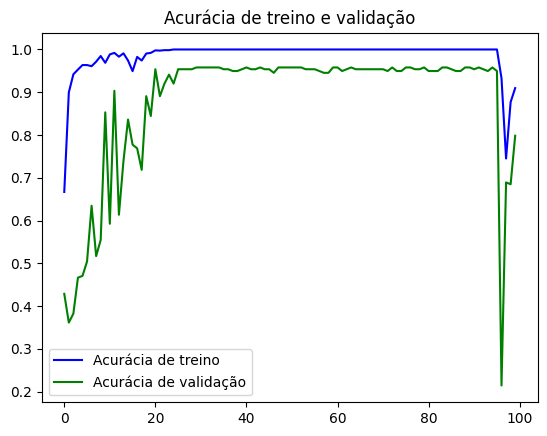

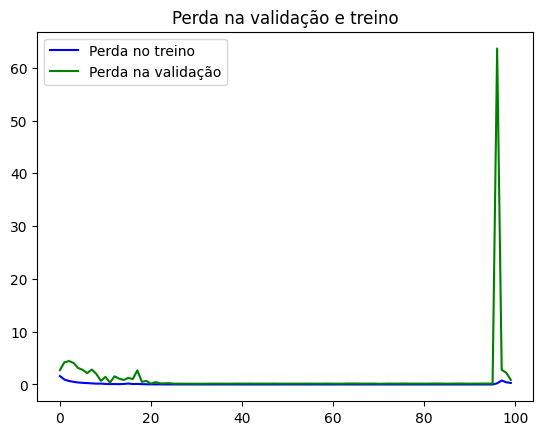

In [30]:
import matplotlib.pyplot as plt

accuracy = model_trained.history['acc']
val_accuracy = model_trained.history['val_acc']
loss = model_trained.history['loss']
val_loss = model_trained.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Acurácia de treino')
plt.plot(epochs, val_accuracy, 'g', label='Acurácia de validação')
plt.title('Acurácia de treino e validação')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Perda no treino')
plt.plot(epochs, val_loss, 'g', label='Perda na validação')
plt.title('Perda na validação e treino')
plt.legend()
plt.show()

In [31]:
#avalia a fase de teste

model_loss, model_accuracy = new_model.evaluate(test_x, test_y, verbose=1)

#mostra o resultado
print('Test loss:', model_loss)
print('Test accuracy:', model_accuracy)

8/8 [==============================] - 0s 39ms/step - loss: 1.0582 - acc: 0.7797
Test loss: 1.0581927299499512
Test accuracy: 0.7796609997749329


In [32]:
#faz a predição das imagens

from tensorflow.keras.utils import to_categorical

pred = new_model.predict(test_x, verbose=0)

pred_probs = np.argmax(pred,axis=1)

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [34]:
cm = confusion_matrix(test_y, pred_probs)

In [35]:
#gera os valores de falso positivo, falso negativo, verdadeiro positivo e verdadeiro negativo
fp = cm.sum(axis=0) - np.diag(cm)  
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.sum() - (fp + fn + tp)

f1score = f1_score(test_y, pred_probs, average='weighted')
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
accuracy    = (tp + tn) / (tp + tn + fp + fn)
precision   = tp / (tp + fp)


print("F1 Score:", f1score)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Precision:  ", precision)
print("Accuracy:   ", accuracy)

F1 Score: 0.7817094009043325
Sensitivity: [0.75675676 0.98039216 0.50943396 0.87931034]
Specificity: [0.99382716 0.78378378 0.98360656 0.95505618]
Precision:   [0.98245614 0.55555556 0.9        0.86440678]
Accuracy:    [0.91949153 0.82627119 0.87711864 0.93644068]
